In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [33]:
# Import required packages
from sklearn.metrics import accuracy_score, classification_report
from random import shuffle
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import dataread
import classifierutils
import logging
import random
import re

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize.regexp import regexp_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

"""Variables"""

# headers = ['allergies', 'family_history', 'history_illness', 'social_history']
headers = dataread.read_file('top_sectionheaders_50000.txt')
no_sections = 5000

"""Import data"""

# header --> [header, original, tokenized, tokenized_labelled]
header_corpus = {}

for header in headers:
    header_corpus[header] = {}
    header_corpus[header]['label'] = header
    temp = dataread.read_file('section/'+header.replace(' ',
                                                        '_')+str(no_sections)+'.txt')
    new = []
    for sample in temp:
        kek = re.sub("\[.*?\]", "", sample)
        new.append(kek)

    header_corpus[header]['original'] = pd.Series(
        new
    )
    temp = classifierutils.corpus_preprocess(
        header_corpus[header]['original'],
        header
    )
    header_corpus[header]['labelled'] = temp[0]
    header_corpus[header]['labelled_tokenised'] = temp[1]

mixed_labelled = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled = mixed_labelled.append(value['labelled'])

mixed_labelled_tokenised = pd.DataFrame()
for value in header_corpus.values():
    mixed_labelled_tokenised = mixed_labelled_tokenised.append(
        value['labelled_tokenised'])

mixed_labelled = shuffle(mixed_labelled)

'Variables'

'Import data'

In [34]:
mixed_labelled.head()

,TEXT,HEADER
406,patient lives wife home smoke drink alcohol,social history
1883,home service,discharge disposition
3633,coronary artery disease ischemic cardiomyopath...,past medical history
3231,aphasia right sided weakness,chief complaint
2286,total right hip replacement,major surgical or invasive procedure


In [35]:
mixed_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44633 entries, 406 to 3255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TEXT    44633 non-null  object
 1   HEADER  44633 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [36]:
mixed_labelled.HEADER.value_counts()

history of present illness              4707
past medical history                    4674
allergies                               4556
social history                          4302
discharge medications                   4080
medications on admission                3947
chief complaint                         3854
family history                          3853
discharge disposition                   3593
brief hospital course                   3541
major surgical or invasive procedure    3526
Name: HEADER, dtype: int64

In [37]:
mixed_labelled['HEADER'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Samples', 
                                                                title='Number of samples in each section header')

In [38]:
def print_plot(index):
    example = mixed_labelled[mixed_labelled.index == index][['TEXT', 'HEADER']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [39]:
print_plot(10)

pericardiocentesis egd biopsy
Product: major surgical or invasive procedure


In [40]:
print_plot(200)

respiratory distress hypoxia
Product: chief complaint


In [41]:
mixed_labelled = mixed_labelled.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].apply(clean_text)

In [42]:
mixed_labelled['TEXT'] = mixed_labelled['TEXT'].str.replace('\d+', '')

In [43]:
print_plot(10)

year old male severe copd etensive cardiac history since surgery patient always complained sternal click incisional discomfort finding confirmed postoperative visit time incisional discomfort described mild affect routine adl however last several weeks following another bout pneumonia significant coughing episodes sternal click incisional discomfort significantly worsened currently rates pain longer able function denies fevers chills palpitations orthopnea pnd syncope pedal edema completed course prednisone levofloacin presumed pneumonia ace inhibitor also recently stopped due persistent dry cough presents surgical repair
Product: history of present illness


In [44]:
print_plot(100)

lopressor mg p b colace mg p b tylenol one two p q hours p r n
Product: discharge medications


In [45]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(mixed_labelled['TEXT'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28689 unique tokens.


In [46]:
X = tokenizer.texts_to_sequences(mixed_labelled['TEXT'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44633, 250)


In [47]:
Y = pd.get_dummies(mixed_labelled['HEADER']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (44633, 11)


In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(40169, 250) (40169, 11)
(4464, 250) (4464, 11)


In [49]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model.add(Bidirectional(LSTM(EMBEDDING_DIM)))
model.add(Dense(EMBEDDING_DIM, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 5,182,011
Trainable params: 5,182,011
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
565/565 [==============================] - 632s 1s/step - loss: 0.7089 - accuracy: 0.7619 - val_loss: 0.3850 - val_accuracy: 0.8867
Epoch 2/10
565/565 [==============================] - 687s 1s/step - loss: 0.2588 - accuracy: 0.9187 - val_loss: 0.2991 - val_accuracy: 0.9086
Epoch 3/10
565/565 [==============================] - 618s 1s/step - loss: 0.2014 - accuracy: 0.9339 - val_loss: 0.2977 - val_accuracy: 0.9081
Epoch 4/10
 89/565 [===>..........................] - ETA: 8:41 - loss: 0.1745 - accuracy: 0.9438

KeyboardInterrupt: 

In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

28/28 [==============================] - 2s 72ms/step - loss: 0.4637 - accuracy: 0.8754
Test set
  Loss: 0.464
  Accuracy: 0.875


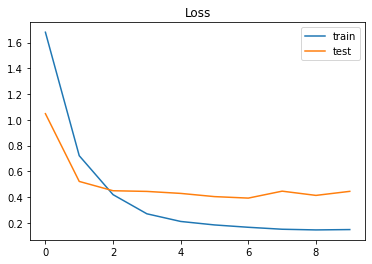

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

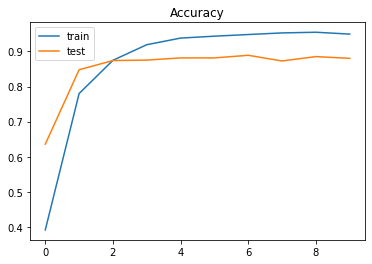

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [29]:
new_complaint = ["""No Known Drug Allergies"""]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = sorted(headers)
print(labels)
print(pred, labels[np.argmax(pred)])

['allergies', 'brief hospital course', 'chief complaint', 'discharge disposition', 'discharge medications', 'family history', 'history of present illness', 'major surgical or invasive procedure', 'medications on admission', 'past medical history', 'social history']
[[9.9981397e-01 9.7910299e-07 4.1671600e-09 4.4652990e-07 1.0913316e-09
  2.1625687e-05 5.8277533e-07 1.9846435e-07 6.0952783e-07 1.2517748e-04
  3.6418824e-05]] allergies


In [30]:
model.save('model/LTSM_RNN_Test .h5')

In [31]:
import dataclass
import importlib
dataclass = importlib.reload(dataclass)
samples = pd.DataFrame()
for value in header_corpus.values():
    samples = samples.append(value['labelled'])

data = dataread.read_samples(2)
data_class = []
for item in data:
    data_class.append(
        dataclass.Sample(item)
    )

labels = sorted(headers)

for item in data_class:
    item.paragraph_classify(model, tokenizer, labels)

export = []
for item in data_class:
    item.paragraph_classify_indexed()
    export.append(item.paragraph_classifed_print())

dataread.save_array(export, 'test2.txt')
    

# labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

# corpus = []
# for()


0.9999999747087713 11
0.9999999749560295 11
1.0000000088512024 11
0.9999999844844751 11
0.9999999351102815 11
0.9999999174325467 11
0.9999999694991857 11
1.0000000332693162 11
0.9999999747087713 11
0.9999999611147814 11
1.000000021304004 11
0.9999998499035065 11
1.0000000046546802 11
0.9999999082205733 11
0.9999999231909681 11
0.9999999187763917 11
1.000000121563403 11
0.9999998310873477 11
1.0000000091524388 11
0.9999999118339034 11
0.9999999756691977 11
0.9999999471283019 11
0.9999999390737457 11
1.0000001820796616 11
0.9999999789429239 11
0.9999999880892574 11
1.0000000613729298 11
0.9999999422709607 11
1.0000002262028964 11
1.00000006170103 11
1.0000000626541805 11
1.0000000307326218 11
1.000000038030521 11
0.9999999024858397 11
1.0000001138431927 11
1.0000000626027798 11
0.9999998841958586 11
1.0000000770655504 11
0.9999999398543196 11
0.9999999536409376 11
1.000000127272756 11
1.000000051337338 11
0.999999912324256 11
0.999999962747097 11
0.999999898257613 11
0.9999999981073415 1

In [32]:
# from keras.models import load_model

# model = load_model('model/LTSM_RNN.h5')